In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydelfi.score as score
import elfi
import pickle
import warnings
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.pyplot import colorbar
from libLN import LogNormalField
from os import makedirs
makedirs("pools_sbi", exist_ok=True)
%matplotlib inline
%run config_10.py
# %run config_02.py

Figures saved at figures/Output20_05_10_80_80_500_80_1_123456
Simulations saved at data/Sims20_05_10_80_80_500_80_1_123456


In [2]:
# Set the seed for reproducibility
np.random.seed(seed)

# Set up the simulator and compressor

In [3]:
LN = LogNormalField(Lside,rmax,nbin)
npar = 2
ndata = LN.nonzerobins

In [4]:
def ssimulator(alpha, beta, simulator_args, batch_size=1, random_state=None):
    
    Lside = simulator_args[0]
    PixelNoise = simulator_args[1]
    
    np.random.seed(seed)
    result = np.zeros((batch_size, ndata))
    
    for i in range(batch_size):
#         if(i % 10==0):
#             print('Simulation',i,'/',batch_size,' done')
        
        sim = LN.run_simulation(alpha,beta,PixelNoise)
        cor = LN.compute_corrfn(sim)

        result[i,:] = cor
    
    return result


simulator_args = np.array([LN.Lside,PixelNoise],dtype=('i4','f4'))

In [5]:
# Load simulations at the fiducial point
theta_fiducial = np.array([alpha, beta])
sims = np.load(simsout+'.npy')
print('Loading from '+simsout+'.npy')
mu, cov = np.mean(sims[:]['corrfn'], axis=0), np.cov(sims[:]['corrfn'].T)
print('Condition number of covariance matrix =',np.linalg.cond(cov))
Cinv  = np.linalg.inv(cov)

Loading from data/Sims20_05_10_80_80_500_80_1_123456.npy
Condition number of covariance matrix = 3766.552804153464


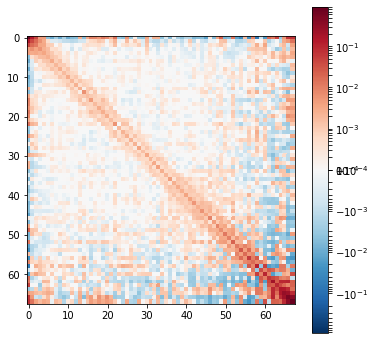

In [6]:
# Plot the covariance matrix:

import matplotlib.colors as colors
plt.figure(figsize=(6,6))
plt.pcolormesh(np.arange(ndata), np.arange(ndata), cov,
                       norm=colors.SymLogNorm(linthresh=0.0001, linscale=0.001,
                                              vmin=-cov.max(), vmax=cov.max(), base=10),
                       cmap='RdBu_r', shading='auto')

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

In [7]:
# Generate derivative of \mu w.r.t cosmological parameters
dmdt = np.array([LN.dxi_LN_dalpha(LN.average_r, beta, alpha, PixelNoise), LN.dxi_LN_dbeta(LN.average_r, beta, alpha, PixelNoise)])

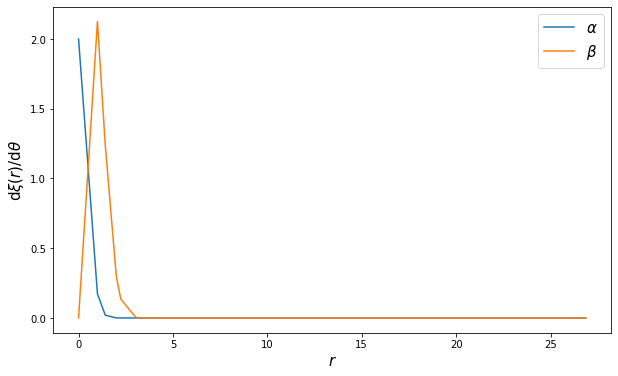

In [8]:
# Plot the gradients of the correlation function

plt.figure(figsize=(10,6))
plt.xlabel('$r$',fontsize=15)
plt.ylabel('$\mathrm{d}\\xi(r)/\mathrm{d}\\theta$',fontsize=15)
# plt.ylim([-1.5,3])

# plt.plot(LN.average_r,mu)
plt.plot(LN.average_r, dmdt[0], label="$\\alpha$")
plt.plot(LN.average_r, dmdt[1], label="$\\beta$")

plt.legend(fontsize=15)

In [9]:
Compressor = score.Gaussian(ndata, theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmdt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, batch_size=1, random_state=None):
    return Compressor.scoreMLE(d)

# Load and compress observed data

In [10]:
compressed_data = np.zeros((nsims,npar))
for f in range(nsims):
    lognormfields = np.load(simsout+'.npy')
    data = lognormfields[f]['corrfn']
    compressed_data[f] = compressor(data)
    np.save(simsout+'_compressed', compressed_data)

nfields = 4
f=2
compressed_data[:nfields,:]

array([[1.58911779, 0.50353226],
       [1.4489542 , 0.47515881],
       [1.24787316, 0.55144048],
       [1.5280079 , 0.64800289]])

# Set up ELFI model

In [11]:
def simulator(alpha, beta, simulator_args, batch_size=1, random_state=None):
    data = ssimulator(alpha, beta, simulator_args, 1, random_state)[0]
    return data

simulator_vec = elfi.tools.vectorize(simulator, [2])

compressor_vec = elfi.tools.vectorize(compressor, [1])

In [12]:
elfi_alpha = elfi.Prior('uniform', alphamin, alphamax-alphamin)
elfi_beta = elfi.Prior('uniform', betamin, betamax-betamin)

In [13]:
# Add the simulator node and observed data to the model
elfi_sim = elfi.Simulator(simulator_vec, elfi_alpha, elfi_beta, simulator_args)

elfi_comp = elfi.Simulator(compressor_vec, elfi_sim, observed=compressed_data[f])

# Specify distance as euclidean between summary vectors (S1, S2) from simulated and
# observed data
elfi_disc = elfi.Distance('euclidean', elfi_comp)

In [14]:
# elfi.draw(elfi_disc)

# Define simulation pool

In [15]:
poolid = "arraypool_"+str(seed)
prefix = "pools_sbi/pool_"+runid
makedirs(prefix, exist_ok=True)
makedirs(prefix+"/"+poolid, exist_ok=True)

# Run likelihood-free inference

## Likelihood-free rejection sampling

In [16]:
try:
    pool = elfi.ArrayPool.open(poolid, prefix=prefix)
    print("Using existing pool at "+prefix+"/"+poolid)
except IOError:
    print("Using new pool at "+prefix+"/"+poolid)
    pool = elfi.ArrayPool(['elfi_alpha', 'elfi_beta', 'elfi_sim', 'elfi_comp'], prefix=prefix)

Using existing pool at pools_sbi/pool_20_05_10_80_80_500_80_1_123456/arraypool_123456


In [17]:
# elfi.set_client('multiprocessing')
rej = elfi.Rejection(elfi_disc, pool=pool, batch_size=1, seed=seed)

In [18]:
schedule = [1.0,0.80,0.50,0.30,0.20,0.15,0.10,0.05]
epsilon = schedule[0]
rej.set_objective(500, threshold=epsilon)

In [19]:
import time
time0 = time.time()
time1 = time0 + 60*60*12
time2 = time0 + 60
while not rej.finished and time.time() < time1:
    rej.iterate()
    if time.time() > time2:
        pool.save()
        time2=time.time() + 60
        print(str(time.time())+", saving")
print(rej.finished)
pool.save()

True


In [20]:
pool.save()
res = rej.extract_result()
pool.close()
res

Method: Rejection
Number of samples: 500
Number of simulations: 609
Threshold: 0.981
Sample means: elfi_alpha: 0.865, elfi_beta: 0.512

## SMC-ABC

In [21]:
try:
    print("Using existing pool at "+prefix+"/"+poolid)
    pool = elfi.ArrayPool.open(poolid, prefix=prefix)
except IOError:
    print("Using new pool at "+prefix+"/"+poolid)
    pool = elfi.ArrayPool(['elfi_alpha', 'elfi_beta', 'elfi_sim', 'elfi_comp'], prefix=prefix)

Using existing pool at pools_sbi/pool_20_05_10_80_80_500_80_1_123456/arraypool_123456


In [22]:
# elfi.set_client('multiprocessing')
smc = elfi.SMC(elfi_disc, pool=pool, batch_size=1, seed=seed)

In [ ]:
# %%capture
N = 3000
schedule = [1.0,0.80,0.50,0.30,0.20,0.15,0.10,0.05]
epsilon = schedule[-1]
smc.sample(N, schedule)
print(smc.finished)

In [ ]:
pool.save()
res = smc.extract_result()
pool.close()
res

## Extract results

In [23]:
def get_kde_values(alpha_samples,beta_samples):
    from scipy.stats import gaussian_kde
    values = np.vstack([alpha_samples, beta_samples])
    kernel = gaussian_kde(values)

    A, B = np.mgrid[alphamin:alphamax:nalpha*1j, betamin:betamax:nbeta*1j]
    positions = np.vstack([A.ravel(), B.ravel()])
    Z = np.reshape(kernel(positions).T, A.shape).T
    Z = np.log(Z)
    Z -= np.max(Z)
    return Z

def twoD_Gaussian(params, xo, yo, a, b, c):
    x=params[0]
    y=params[1]
    xo = float(xo)
    yo = float(yo)
    detC = (a*c-b*b)
    lnL = -1/2*(2*np.pi)**2*detC - 1/2 * 1/detC * (c*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + a*((y-yo)**2))
    lnL -= lnL.max()
    return lnL.ravel()

def get_FoM(lnL, initial_guess = (0.010, 0., 0.0005)):
    from scipy.optimize import curve_fit
    alphas=np.linspace(alphamin,alphamax,nalpha)
    betas=np.linspace(betamin,betamax,nbeta)
    A, B = np.mgrid[alphamin:alphamax:nalpha*1j, betamin:betamax:nbeta*1j]
    
    maxpos = np.where(lnL==lnL.max())
    alphamode, betamode = float(A[maxpos]), float(B[maxpos])
    
    func=np.where(lnL == -np.inf, np.nanmin(lnL[lnL != -np.inf]), lnL).reshape(nalpha*nbeta)
    twoD_Gaussian_mode = lambda params, a, b, c : twoD_Gaussian(params, alphamode, betamode, a, b ,c)
    
    popt, pcov = curve_fit(twoD_Gaussian_mode, np.array([A, B]), func, p0=initial_guess, maxfev=100000)
    detC=popt[0]*popt[2]-popt[1]*popt[1]
    fom=1/np.sqrt(detC)
    return np.hstack([alphamode, betamode, popt, fom])

In [24]:
# alpha_samples = res.samples['elfi_alpha']
# beta_samples = res.samples['elfi_beta']
# disc_samples = res.discrepancies

In [25]:
alpha_pool=np.load(prefix+"/"+poolid+"/elfi_alpha.npy")
beta_pool=np.load(prefix+"/"+poolid+"/elfi_beta.npy")
sim_pool=np.load(prefix+"/"+poolid+"/elfi_sim.npy")
comp_pool=np.load(prefix+"/"+poolid+"/elfi_comp.npy")
pool_size=alpha_pool.shape[0]
print("pool size:",pool_size)
np.savez(dataout+'_sbi_pool.npz',alpha_pool=alpha_pool[:10000],beta_pool=beta_pool[:10000],comp_pool=comp_pool[:10000])

pool size: 681742


In [26]:
epsilons = np.array(schedule)
disc_pool = np.zeros((nfields,pool_size))
alpha_marginal_stds = {}
beta_marginal_stds = {}
alpha_samples = {}
beta_samples = {}
disc_samples = {}
sample_size = {}
kde = {}
fom = {}
fit = {}

for f in range(nfields):
    disc_pool[f] = np.linalg.norm(comp_pool-compressed_data[f],axis=1)
    
    for epsilon in epsilons:
        foo = np.where(disc_pool[f]<epsilon)
        sample_size[f,epsilon] = foo[0].shape
        alpha_samples[f,epsilon] = alpha_pool[foo]
        beta_samples[f,epsilon] = beta_pool[foo]
        alpha_marginal_stds[f,epsilon] = np.std(alpha_samples[f,epsilon])
        beta_marginal_stds[f,epsilon] = np.std(beta_samples[f,epsilon])
        disc_samples[f,epsilon] = disc_pool[f][foo]
        sbi_samples=np.array((alpha_samples[f,epsilon],beta_samples[f,epsilon])).T
        sbi_weigths=np.ones(alpha_samples[f,epsilon].shape[0])
        kde[f,epsilon] = get_kde_values(alpha_samples[f,epsilon][:10000],beta_samples[f,epsilon][:10000])
        cov = np.cov(alpha_samples[f,epsilon], beta_samples[f,epsilon])
        fom[f,epsilon] = np.linalg.det(cov)**(-1/2)
        fit[f,epsilon] = get_FoM(kde[f,epsilon])
        print("field {}, eps={}: acceptance = {:.3f}, {} samples, FoM_samples={:.3f}, FoM_fit={:.3f}".\
              format(f, epsilon,sample_size[f,epsilon][0]/pool_size, sample_size[f,epsilon][0], fom[f,epsilon], fit[f,epsilon][-1]))
        np.savez(dataout+'_sbi_field'+str(f)+'_eps'+str(int(100*epsilon))+'_samples_posterior.npz',
                 samples=sbi_samples, weights=sbi_weigths, disc=disc_samples[f,epsilon])    

    np.savez(dataout+'_sbi_field'+str(f)+'.npz', epsilons=epsilons,
             sample_size=np.array([sample_size[f,epsilon] for epsilon in epsilons]),
             fit=np.array([fit[f,epsilon] for epsilon in epsilons]),
             alpha_marginal_stds=np.array([alpha_marginal_stds[f,epsilon] for epsilon in epsilons]),
             beta_marginal_stds=np.array([beta_marginal_stds[f,epsilon] for epsilon in epsilons]))
    print("---------------------------------")
    
lnL = {}
fit_all = {}
for epsilon in epsilons:
    lnL[epsilon] = np.zeros((nalpha,nbeta))
    lnL[epsilon] = np.sum([kde[f,epsilon] for f in range(nfields)],axis=0)
    lnL[epsilon] -= lnL[epsilon].max()
    fit_all[epsilon] = get_FoM(lnL[epsilon])
    print("{} fields combined, eps={}: FoM_fit={}".format(nfields, epsilon, fit_all[epsilon][-1]))

field 0, eps=1.0: acceptance = 0.792, 540191 samples, FoM_samples=13.919, FoM_fit=4.841
field 0, eps=0.8: acceptance = 0.665, 453686 samples, FoM_samples=14.518, FoM_fit=6.335
field 0, eps=0.5: acceptance = 0.359, 244949 samples, FoM_samples=17.233, FoM_fit=9.241
field 0, eps=0.3: acceptance = 0.170, 116145 samples, FoM_samples=20.516, FoM_fit=12.229
field 0, eps=0.2: acceptance = 0.083, 56315 samples, FoM_samples=24.244, FoM_fit=21.677
field 0, eps=0.15: acceptance = 0.046, 31203 samples, FoM_samples=28.197, FoM_fit=39.358
field 0, eps=0.1: acceptance = 0.020, 13441 samples, FoM_samples=35.307, FoM_fit=53.931
field 0, eps=0.05: acceptance = 0.005, 3350 samples, FoM_samples=43.792, FoM_fit=105.068
---------------------------------
field 1, eps=1.0: acceptance = 0.802, 546698 samples, FoM_samples=13.846, FoM_fit=4.608
field 1, eps=0.8: acceptance = 0.730, 497988 samples, FoM_samples=14.085, FoM_fit=5.341
field 1, eps=0.5: acceptance = 0.452, 308045 samples, FoM_samples=15.685, FoM_fit=8

Text(0.5, 0, 'discrepancy')

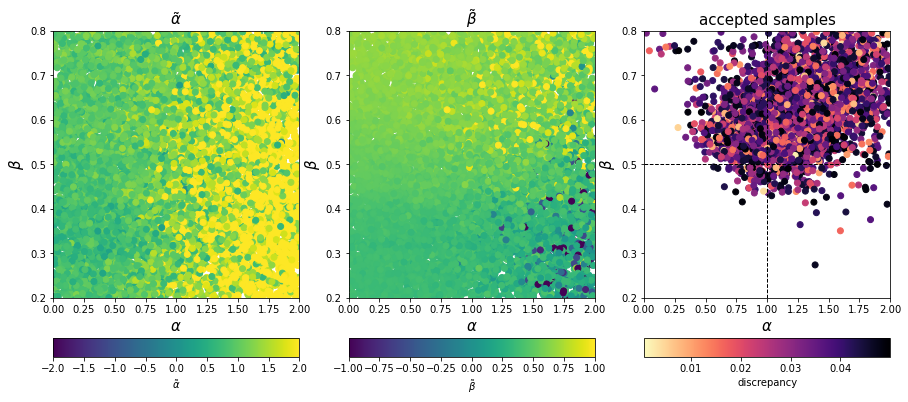

In [27]:
N=10000
fig=plt.figure(figsize=(15,6))

ax0=fig.add_subplot(1,3,1)
ax0.set_xlabel("$\\alpha$",fontsize=15)
ax0.set_ylabel("$\\beta$",fontsize=15)
ax0.set_title("$\\tilde{\\alpha}}$",fontsize=15)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
im0 = ax0.scatter(alpha_pool[:N], beta_pool[:N], c=comp_pool[:N].T[0], vmin=-2., vmax=2.)
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad="15%")
cb0 = colorbar(im0, cax=cax0, orientation="horizontal")
cb0.ax.set_xlabel("$\\tilde{\\alpha}$")

ax1=fig.add_subplot(1,3,2)
ax1.set_xlabel("$\\alpha$",fontsize=15)
ax1.set_ylabel("$\\beta$",fontsize=15)
ax1.set_title("$\\tilde{\\beta}$",fontsize=15)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
im1 = ax1.scatter(alpha_pool[:N], beta_pool[:N], c=comp_pool[:N].T[1], vmin=-1., vmax=1.)
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="15%")
cb1 = colorbar(im1, cax=cax1, orientation="horizontal")
cb1.ax.set_xlabel("$\\tilde{\\beta}$")

ax2=fig.add_subplot(1,3,3)
ax2.set_xlabel("$\\alpha$",fontsize=15)
ax2.set_ylabel("$\\beta$",fontsize=15)
ax2.set_title("accepted samples",fontsize=15)
ax2.set_xlim([alphamin,alphamax])
ax2.set_ylim([betamin,betamax])
ax2.axvline(alpha,lw=1,ls="--",color="k")
ax2.axhline(beta,lw=1,ls="--",color="k")
im2 = ax2.scatter(alpha_samples[f,epsilon][:N], beta_samples[f,epsilon][:N], c=disc_samples[f,epsilon][:N], cmap='magma_r')
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("bottom", size="7%", pad="15%")
cb2 = colorbar(im2, cax=cax2, orientation="horizontal")
cb2.ax.set_xlabel("discrepancy")

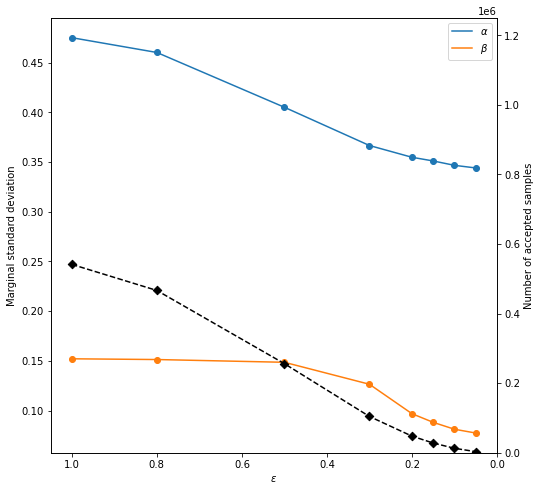

In [28]:
fig=plt.figure(figsize=(8,8))

ax0=fig.add_subplot(1,1,1)
ax0.set_xlim([1.05,0])
ax0.set_xlabel("$\\varepsilon$")
ax0.set_ylabel("Marginal standard deviation")
ax0.scatter(epsilons,[alpha_marginal_stds[f,epsilon] for epsilon in epsilons],marker='o',color='C0')
ax0.plot(epsilons,[alpha_marginal_stds[f,epsilon] for epsilon in epsilons],ls='-',color='C0',label='$\\alpha$')
ax0.scatter(epsilons,[beta_marginal_stds[f,epsilon] for epsilon in epsilons],marker='o',color='C1')
ax0.plot(epsilons,[beta_marginal_stds[f,epsilon] for epsilon in epsilons],ls='-',color='C1',label="$\\beta$")

ax1=ax0.twinx()
ax1.set_ylim(0,1.25e6)
ax1.set_ylabel("Number of accepted samples")
ax1.scatter(epsilons,[sample_size[f,epsilon] for epsilon in epsilons],marker='D',color='k')
ax1.plot(epsilons,[sample_size[f,epsilon] for epsilon in epsilons],ls='--',color='k')

ax0.legend(loc="best")

# Combination of several independent fields

Text(0.5, 0, 'discrepancy')

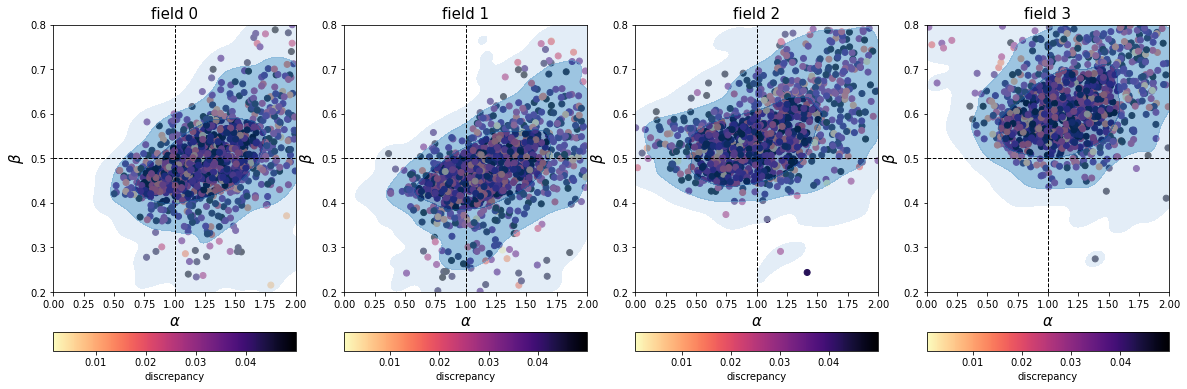

In [29]:
N=1000
epsilon=0.05
alphas=np.linspace(alphamin,alphamax,nalpha)
betas=np.linspace(betamin,betamax,nbeta)
A, B = np.mgrid[alphamin:alphamax:nalpha*1j, betamin:betamax:nbeta*1j]

fig=plt.figure(figsize=(20,6))
ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$",fontsize=15)
ax0.set_ylabel("$\\beta$",fontsize=15)
ax0.set_title("field 0",fontsize=15)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
im0 = ax0.scatter(alpha_samples[0,epsilon][:N], beta_samples[0,epsilon][:N], c=disc_samples[0,epsilon][:N], cmap='magma_r')
ax0.contourf(alphas,betas,kde[0,epsilon],contour_levels,cmap="Blues",alpha=0.5)
# ft0 = twoD_Gaussian(np.array([A, B]), fit[0,epsilon][0], fit[0,epsilon][1], fit[0,epsilon][2], fit[0,epsilon][3], fit[0,epsilon][4])
# ax0.contourf(alphas,betas,ft0.reshape(nalpha,nbeta),contour_levels,cmap="Greens",alpha=0.5)
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad="15%")
cb0 = colorbar(im0, cax=cax0, orientation="horizontal")
cb0.ax.set_xlabel("discrepancy")

ax1=fig.add_subplot(1,4,2)
ax1.set_xlabel("$\\alpha$",fontsize=15)
ax1.set_ylabel("$\\beta$",fontsize=15)
ax1.set_title("field 1",fontsize=15)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
ax1.axvline(alpha,lw=1,ls="--",color="k")
ax1.axhline(beta,lw=1,ls="--",color="k")
im1 = ax1.scatter(alpha_samples[1,epsilon][:N], beta_samples[1,epsilon][:N], c=disc_samples[1,epsilon][:N], cmap='magma_r')
ax1.contourf(alphas,betas,kde[1,epsilon],contour_levels,cmap="Blues",alpha=0.5)
# ft1 = twoD_Gaussian(np.array([A, B]), fit[1,epsilon][0], fit[1,epsilon][1], fit[1,epsilon][2], fit[1,epsilon][3], fit[1,epsilon][4])
# ax1.contourf(alphas,betas,ft1.reshape(nalpha,nbeta),contour_levels,cmap="Greens",alpha=0.5)
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="15%")
cb1 = colorbar(im1, cax=cax1, orientation="horizontal")
cb1.ax.set_xlabel("discrepancy")

ax2=fig.add_subplot(1,4,3)
ax2.set_xlabel("$\\alpha$",fontsize=15)
ax2.set_ylabel("$\\beta$",fontsize=15)
ax2.set_title("field 2",fontsize=15)
ax2.set_xlim([alphamin,alphamax])
ax2.set_ylim([betamin,betamax])
ax2.axvline(alpha,lw=1,ls="--",color="k")
ax2.axhline(beta,lw=1,ls="--",color="k")
im2 = ax2.scatter(alpha_samples[2,epsilon][:N], beta_samples[2,epsilon][:N], c=disc_samples[2,epsilon][:N], cmap='magma_r')
ax2.contourf(alphas,betas,kde[2,epsilon],contour_levels,cmap="Blues",alpha=0.5)
# ft2 = twoD_Gaussian(np.array([A, B]), fit[2,epsilon][0], fit[2,epsilon][1], fit[2,epsilon][2], fit[2,epsilon][3], fit[2,epsilon][4])
# ax2.contourf(alphas,betas,ft2.reshape(nalpha,nbeta),contour_levels,cmap="Greens",alpha=0.5)
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("bottom", size="7%", pad="15%")
cb2 = colorbar(im2, cax=cax2, orientation="horizontal")
cb2.ax.set_xlabel("discrepancy")

ax3=fig.add_subplot(1,4,4)
ax3.set_xlabel("$\\alpha$",fontsize=15)
ax3.set_ylabel("$\\beta$",fontsize=15)
ax3.set_title("field 3",fontsize=15)
ax3.set_xlim([alphamin,alphamax])
ax3.set_ylim([betamin,betamax])
ax3.axvline(alpha,lw=1,ls="--",color="k")
ax3.axhline(beta,lw=1,ls="--",color="k")
im3 = ax3.scatter(alpha_samples[3,epsilon][:N], beta_samples[3,epsilon][:N], c=disc_samples[3,epsilon][:N], cmap='magma_r')
ax3.contourf(alphas,betas,kde[3,epsilon],contour_levels,cmap="Blues",alpha=0.5)
# ft3 = twoD_Gaussian(np.array([A, B]), fit[3,epsilon][0], fit[3,epsilon][1], fit[3,epsilon][2], fit[3,epsilon][3], fit[3,epsilon][4])
# ax3.contourf(alphas,betas,ft3.reshape(nalpha,nbeta),contour_levels,cmap="Greens",alpha=0.5)
ax3_divider = make_axes_locatable(ax3)
cax3 = ax3_divider.append_axes("bottom", size="7%", pad="15%")
cb3 = colorbar(im3, cax=cax3, orientation="horizontal")
cb3.ax.set_xlabel("discrepancy")

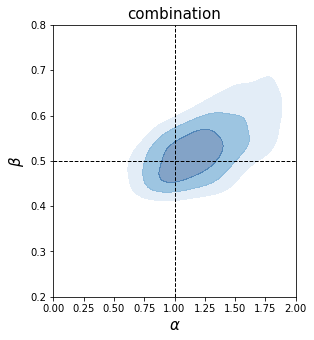

In [30]:
alphas=np.linspace(alphamin,alphamax,nalpha)
betas=np.linspace(betamin,betamax,nbeta)

fig=plt.figure(figsize=(20,5))
ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$",fontsize=15)
ax0.set_ylabel("$\\beta$",fontsize=15)
ax0.set_title("combination",fontsize=15)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
ax0.contourf(alphas,betas,lnL[epsilon],contour_levels,cmap="Blues",alpha=0.5)
# ft = twoD_Gaussian(np.array([A, B]), fit_all[epsilon][0], fit_all[epsilon][1], fit_all[epsilon][2], fit_all[epsilon][3], fit_all[epsilon][4])
# ax0.contourf(alphas,betas,ft.reshape(nalpha,nbeta),contour_levels,cmap="Greens",alpha=0.5)

In [31]:
for epsilon in epsilons:
    np.savez(dataout+'_sbi_eps'+str(int(100*epsilon))+'_'+str(nfields)+'fields',alphas=alphas,betas=betas,
             lnL0=kde[0,epsilon],
             lnL1=kde[1,epsilon],
             lnL2=kde[2,epsilon],
             lnL3=kde[3,epsilon],
             lnL=lnL[epsilon],
             fit_all=fit_all[epsilon])